In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%run ../modules/plotting_metrics.py

In [2]:
from memoization import cached


In [3]:
# Hold-out and Cross Validation

In [4]:
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

# Stratified k-fold Cross Validation

In [78]:
def plot_swarm_metrics(df_results, metric_name):
    sns.set(context='talk', style='whitegrid', font_scale=0.8)
    
    df_melted = pd.melt(df_results.loc[metric_name], var_name='method', value_name=metric_name)

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.swarmplot(data=df_melted, x='method', y=metric_name,
                      size=6)
    sns.pointplot(data=df_melted, x='method', y=metric_name, dodge=True,
                  ci=95, ax=ax, join=False, color='black', capsize=0.4)
    ax.set(
        title=f'ML vs CS results: {metric_name.replace("_", " ").upper()}',
           xlabel='VS Method')


### Normality and Homocedasticity

In [143]:
from scipy.stats import shapiro, bartlett, levene

def norm_test(x, alpha=0.05):
    s, p = shapiro(x)
    result = 'rejected' if p < alpha else 'accepted'
    print(f'The H0 is {result} => (W={round(s, 3)}, p={round(p, 3)})')
    
def homovar_test(x, y, alpha=0.05):
    s, p = bartlett(x, y)
    result = 'rejected' if p < alpha else 'accepted'
    print(f'The H0 is {result} => (W={round(s, 3)}, p={round(p, 3)})')
    
def multi_norm_test(df, alpha=0.05):
    res = df.loc['roc_auc'].apply(shapiro, axis=0)
    return pd.DataFrame([0 if i[1] < alpha else 1 for i in res], 
             index=df.columns, columns=['Normality']).T

def multi_homovar_test(df, alpha=0.05, as_df=True):
    res = bartlett(*cv5x2.loc['roc_auc'].values)
    if as_df:
        res = pd.DataFrame(res, columns=['Bartlett'], 
                           index=['statistic', 'p']).T
    return res

## Classifiers and consensus Scorings
### ML Classifiers

In [6]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [8]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [9]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [10]:
from sklearn.ensemble import RandomForestClassifier

hyparams = {'n_estimators': 100, 'min_samples_split': 10,
            'min_samples_leaf': 4, 
            'max_features': 'sqrt', 'max_depth': 10}
rf = RandomForestClassifier(**hyparams)

In [11]:
# ML Classifier
ml_classifiers = {
    'dclf': dclf,
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'rf': rf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [12]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score,
    'RANK': get_rank_score 
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

## Estimators dictionary

In [13]:
estimators = {**ml_classifiers, **cs_functions}

# Cross Validation

In [25]:
%run ./1_Helper_functions.ipynb

In [15]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_002 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

### 5 folds/reps

In [146]:
%%time
cv5 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=5, random_state=42)
# Normality
display(multi_norm_test(cv5))
# Homocedasticity
display(multi_homovar_test(cv5))

cv5.loc['roc_auc']

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.172557,1.0


CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 399 ms


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
0,0.50080,0.79516,0.88112,0.92751,0.87611,0.64234,0.64502,0.57160,0.62889,0.64197
1,0.54065,0.78846,0.86721,0.88513,0.81256,0.60090,0.62607,0.54079,0.60534,0.59789
2,0.48561,0.81858,0.91357,0.91118,0.86218,0.65380,0.67037,0.58591,0.64147,0.65064
3,0.49577,0.80517,0.89885,0.90776,0.87063,0.63146,0.63170,0.54574,0.63917,0.62874
4,0.49795,0.78136,0.91855,0.93413,0.88098,0.65086,0.64554,0.57859,0.62882,0.64914


In [145]:
%%time
ho5 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=5, random_state=42)
# Normality
display(multi_norm_test(ho5))
# Homocedasticity
display(multi_homovar_test(ho5))

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,0,0,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.172557,1.0


CPU times: user 141 ms, sys: 63 µs, total: 141 ms
Wall time: 139 ms


### 15 folds/reps

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,0,1,1,1,1,1,1


,statistic,p
Bartlett,0.172557,1.0


CPU times: user 852 ms, sys: 119 ms, total: 972 ms
Wall time: 752 ms


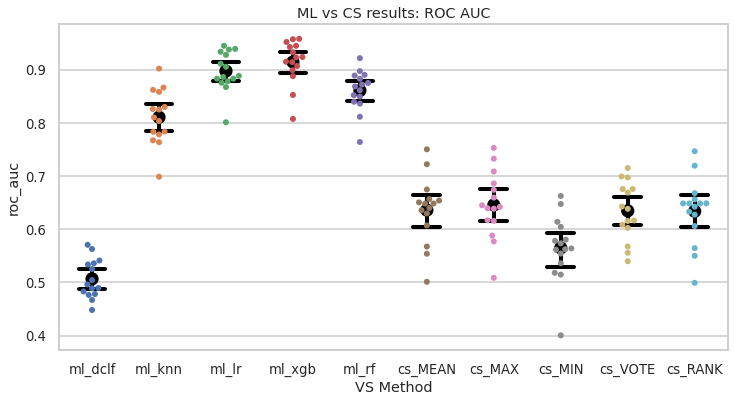

In [147]:
%%time
cv15 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=15, random_state=42)

plot_swarm_metrics(cv15, metric_name='roc_auc')# Normality
# Normality
display(multi_norm_test(cv15))
# Homocedasticity
display(multi_homovar_test(cv15))

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.172557,1.0


CPU times: user 849 ms, sys: 120 ms, total: 969 ms
Wall time: 748 ms


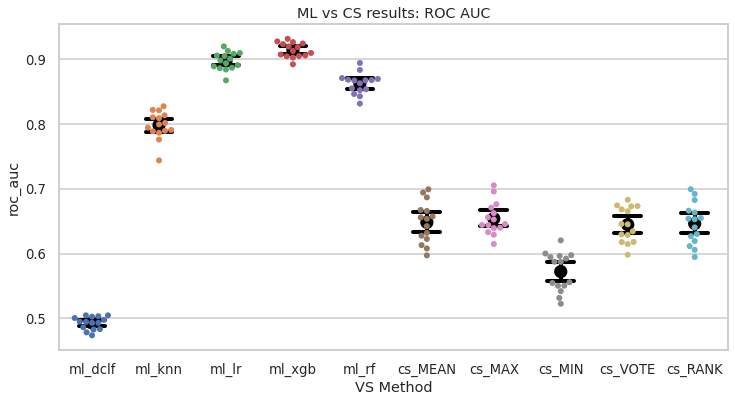

In [148]:
%%time
ho15 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=15, random_state=42)

plot_swarm_metrics(ho15, metric_name='roc_auc')
# Normality
display(multi_norm_test(ho15))
# Homocedasticity
display(multi_homovar_test(ho15))

### 5x2 CV

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.172557,1.0


CPU times: user 819 ms, sys: 104 ms, total: 923 ms
Wall time: 704 ms


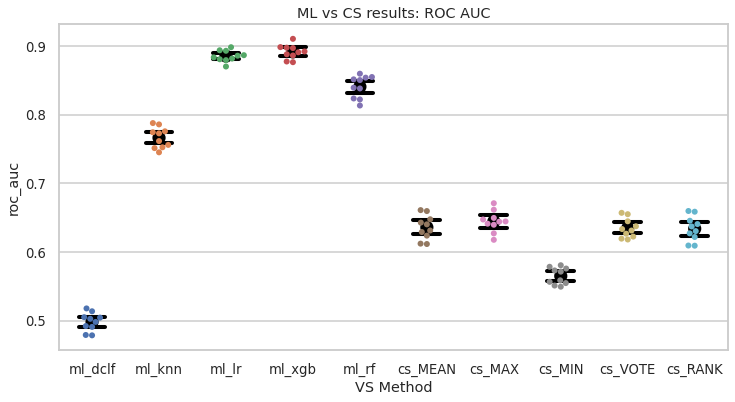

In [149]:
%%time
cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
                      n_splits=2, n_repeats=5, random_state=42)

plot_swarm_metrics(cv5x2, metric_name='roc_auc')
# Normality
display(multi_norm_test(cv5x2))
# Homocedasticity
display(multi_homovar_test(cv5x2))

## Multiple samples
- one-way ANOVA with repeated measures
- Friedman's ANOVA
- Cochran's Q test
- Binomial $\chi^2$ with Bonferroni correction

In [151]:
from statsmodels.stats.anova import AnovaRM

AnovaRM(data=df, )

In [150]:
df = cv5x2.loc['roc_auc']

df

### Two Samples
- Delong
- Nedeau
- Wilcoxon
- Bootstrap
- paired t-test
- McNemar
- 5x2cv F modified

In [95]:
xgb_res = ho15.loc['roc_auc','ml_xgb']
knn_res = ho15.loc['roc_auc','ml_knn']

# Normalidad
norm_test(xgb_res)
norm_test(knn_res)

# Homogeneidad de varianzas
homovar_test(xgb_res, knn_res)

The H0 is accepted => (W=0.953, p=0.571)
The H0 is accepted => (W=0.927, p=0.244)
The H0 is rejected => (W=4.911, p=0.027)


In [33]:
%%time
from mlxtend.evaluate import combined_ftest_5x2cv

f, p = combined_ftest_5x2cv(
        estimator1=estimators['ml_xgb'],
        estimator2=estimators['ml_knn'],
        X=X, y=y,
        scoring='roc_auc',
        random_seed=42
    )

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 30.093
p value: 0.001
CPU times: user 2min 15s, sys: 235 ms, total: 2min 15s
Wall time: 21.3 s


In [34]:
f, p = combined_ftest_5x2cv(
        estimator1=estimators['ml_xgb'],
        estimator2=estimators['ml_lr'],
        X=X, y=y,
        scoring='roc_auc',
        random_seed=42
    )

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 0.730
p value: 0.687


In [20]:


cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

NameError: name 'random_state' is not defined

In [43]:
def standard_error(x):
    return np.std(x)/np.sqrt(len(x) - 1)

standard_error(cv15.loc['roc_auc','ml_xgb'])

0.010609769149082625

In [56]:
import numpy as np
from scipy import stats

def mean_confidence_interval(x, confidence=0.95):
    n = len(x)
    mean, se = np.mean(x), stats.sem(x)
    d = se * stats.t.ppf((1 + confidence)/2, n - 1)
    return mean - d, mean + d

a = cv15.loc['roc_auc','ml_xgb']
mean_confidence_interval(a)

sns.tsplot(a)

AttributeError: module 'seaborn' has no attribute 'tsplot'

In [73]:
import numpy as np, scipy.stats as st

st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(0.8918169750338426, 0.9373283582994908)